# Assignment 4
## Clustering languages
The assignment and data are available here: https://snlp2018.github.io/assignments.html

The main dataset for the assignment is in the file `northeuralex-words.gz`. It contains IPA phonetic representation of more than 1000 words in more than 100 languages of Northern Eurasia; the dataset consists of two tab-separated columns: 3-letter ISO language code and tokenize IPA representation of a word.

### Exercise 1
Read the data and extract the features. In particular, each language in the dataset will be represented as a vector of integers, one for each IPA token in the dataset. Each integer should correspond to the count of the IPA token in the words of that language.

In [96]:
import pandas as pd
import numpy as np

In [2]:
# read data
df_raw = pd.read_csv("data/northeuralex-words", sep = "\t", names = ["lang", "ipa"])
print(df_raw.head()) # let's take a look at df
print(df_raw.groupby("lang").nunique())

lang          ipa
0  fin    s i l m æ
1  fin    k ɔ r ʋ ɑ
2  fin      n ɛ n æ
3  fin        s u u
4  fin  h ɑ m m ɑ s
      lang   ipa
lang            
ava      1   954
azj      1  1017
bak      1   962
bel      1  1042
ben      1   930
...    ...   ...
udm      1   973
ukr      1  1044
uzn      1   960
vep      1  1004
yrk      1  1014

[80 rows x 2 columns]


In [4]:
# uncomment this to experiment with selected languages
#df_raw = df_raw[df_raw["lang"].isin(["ita", "fra", "spa", "por", "eng", "deu", "nld", "swe", "nor", "fin", "tur"])].reset_index(drop = True)

Next, we want to wrangle the df in such a way that we have one language per row and a list of all the IPA tokens appearing in the words of that language as value:

In [3]:
df_by_lang = df_raw.groupby("lang")["ipa"].apply(lambda x: ' '.join(x)) # group by language code and join all rows

In [6]:
print(df_by_lang.head(10))
print(df_by_lang.shape)

lang
ava    ʕ i n m j e ʕ j e r kʼ a l ʕ u s m a t͡s ʼ kʼ ...
azj    ɟ œ z ɡ u l ɑ ɡ b u r u n ɑ ɣ ɯ z d ɪ ʃ d ɪ l ...
bak    k y ð q o l a q t a n a u a u ɯ ð t e ʃ t e l ...
bel    v ɔ k a v u x a n ɔ s r ɔ t z u b j a z ɨ k ɣ ...
ben    t͡ʃ ɔ k kʰ u k ɔ r n o n a k m u kʰ d ã t ɔ d...
bre    l ɑ ɑ ɡ a t s k u u a ʀ n f ʀ i i ɡ ẽ ẽ n u ...
bul    ɔ k ɔ u x ɔ n ɔ s u s t a z ɤ p ɛ z i k u s t ...
cat    u ʎ u ɾ ɛ ʎ ə n a s b ɔ k ə d ɛ n ʎ ɛ n ɣ w ə ...
ces    o k o u x o n o s p u s a z u p j a z ɪ k r ɛ ...
che    b ʡ æ r ɡ l e r ɡ m ə r ə b ə ɡ ə t͡s e r ɡ m ...
Name: ipa, dtype: object
(80,)


Next, we use `CountVectorizer` from `sklearn` to get the feature matrix:

In [5]:
from sklearn.feature_extraction.text import CountVectorizer

In [7]:
cv = CountVectorizer(tokenizer = lambda x : x.split(" "))
cv.fit(df_by_lang)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=<function <lambda> at 0x00000249AB6FD678>,
                vocabulary=None)

In [8]:
features = cv.transform(df_by_lang)

In [9]:
features

<80x273 sparse matrix of type '<class 'numpy.int64'>'
	with 3259 stored elements in Compressed Sparse Row format>

In [10]:
dense_features = features.todense()

In [11]:
dense_features

matrix([[26, 38,  0, ..., 95,  0,  0],
        [ 0, 76,  0, ..., 83,  0,  0],
        [ 5, 67,  0, ...,  0,  0,  0],
        ...,
        [ 0, 69,  0, ..., 27,  0,  0],
        [ 0,  6,  0, ...,  0,  0,  0],
        [ 0, 52,  0, ...,  0,  0,  0]], dtype=int64)

Finally, let's get a list of language codes in the same order:

In [12]:
languages = list(df_by_lang.index) # to make sure we keep the alignment features/labels
languages[0:9]

['ava', 'azj', 'bak', 'bel', 'ben', 'bre', 'bul', 'cat', 'ces']

### Exercise 2
K-means clustering. Repeat clustering of `features` for `k` in `[2,70]` and plot error function and silhouette score for each `k`.

In [13]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [49]:
def kmeans(features, max_k):
    error_scores = [] # initialize arrays to keep track
    sil_scores = []
    
    print("Working on it... Please wait :)")
    
    for k in range(2, max_k + 1):
        km = KMeans(n_clusters = k) # initialize model
        km.fit(features) # fit on data
        km_labels = km.predict(features) # generate labels for cluster
        error = km.inertia_ # get error score (sum of squared distances from centroids)
        silhouette = silhouette_score(features, km_labels) # get silhouette score
        error_scores.append(error)
        sil_scores.append(silhouette)
        
    print("Done!")
    
    return(error_scores, sil_scores)

In [50]:
max_k = 70
error_scores, sil_scores = kmeans(dense_features, max_k)

Working on it... Please wait :)
Done!


Plot scores as a function of `k`:

In [51]:
import matplotlib.pyplot as plt
%matplotlib inline

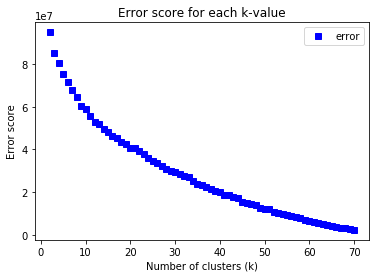

In [52]:
# error
plt.plot(range(2, max_k + 1), error_scores, "bs", label = 'error')
plt.xlabel("Number of clusters (k)")
plt.ylabel('Error score')
plt.legend()
plt.title("Error score for each k-value")
plt.show()

Hard to spot the so-called "elbow" here.

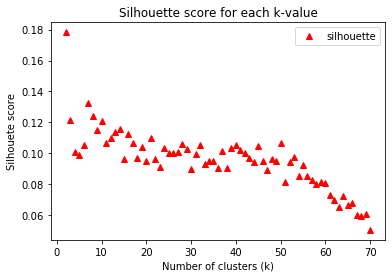

In [53]:
# silhouette
plt.plot(range(2, max_k + 1), sil_scores, "r^", label = 'silhouette')
plt.xlabel("Number of clusters (k)")
plt.ylabel('Silhouete score')
plt.legend()
plt.title("Silhouette score for each k-value")
plt.show()

Is this reasonable?

### Exercise 3
Principal component analysis. Intuitively, some phonemes will correlate with others, hence the information in our `features` is likely redundant. In this exercise we apply PCA to reduce the dimensionality of the data without losing too much information.

First of all, we reduce the dimensionality of `features` to 2 and plot the datapoints in a 2-dimensional space:

In [54]:
from sklearn.decomposition import PCA

In [55]:
pca = PCA(n_components = 2) # initialize
pca.fit(dense_features) # fit on data

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [56]:
print(sum(pca.explained_variance_ratio_))

0.3464744261935182


In [57]:
features2d = pca.transform(dense_features) # reduce dimensionality

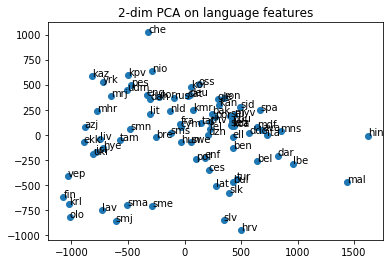

In [58]:
plt.scatter(features2d[:,0], features2d[:,1])
plt.title("2-dim PCA on language features")
for i, lang in enumerate(languages):
    plt.annotate(lang, (features2d[i,0], features2d[i,1]))
plt.show()

What's the lowest number of dimensions which allow us to keep 90% of explained variance? To answer this question we add the variance explained by each dimension until we reach 90%:

In [59]:
pca = PCA(dense_features.shape[0]) # initialize with max value of dimensions
d = 0 # initialize counter to keep track of number of dimensions
var_explained = 0 # initialize to keep track of variance explained
while var_explained < 0.9:
    var_explained += pca.fit(dense_features).explained_variance_ratio_[d] # add explained variance
    d += 1 # increase number of dimensions

print(d)

22


In [60]:
pca = PCA(d) # re-initialize with the found value
pca.fit(dense_features) # fit on data
sum(pca.explained_variance_ratio_) # double check explained variance

0.9074513741988803

In [61]:
featuresPCA = pca.transform(dense_features) # reduce dimensionality to d

### Exercise 4
Evaluation with "true" labels. We now turn to the data in `data/language-family-small.csv`, in particular the fourth column of the dataset, which contains the language families. The idea in this excercise is to cluster the phonetic data as before in a number of clusters which corresponds to the language families found in the df, and check whether the resulting clusters "recover" the language families.

We want to obtain a list of exactly the language families to which the lenguages of the previous excercises belong, in the correct order.

In [62]:
# first we read the df
families_df = pd.read_csv("data/language-family-small.csv", sep = ",", names = ["ISO", "glottocode", "lang", "family", "group"])

In [63]:
families_df.head()

,ISO,glottocode,lang,family,group
0,ava,avar1256,Avar,Nakh-Daghestanian,Daghestanian
1,bak,bash1264,Bashkir,Turkic,Common Turkic
2,bel,bela1254,Belarusian,Indo-European,Balto-Slavic
3,ben,beng1280,Bengali,Indo-European,Indo-Iranian
4,bre,bret1244,Breton,Indo-European,Celtic


In [64]:
families_df.shape

(80, 5)

In order too obtain the desired list, we should first check: Are the languages in `families_df["ISO"]` exactly the same 80 entries in the list `languages` above?

In [65]:
set(languages) == set(families_df["ISO"])

True

Then we only need to make sure the df is in the same order as the list `language` (which is alphabetical) then extract the fourth column:

In [66]:
families_df = families_df.sort_values("ISO").reset_index(drop = True)

In [67]:
families_df.head()

,ISO,glottocode,lang,family,group
0,ava,avar1256,Avar,Nakh-Daghestanian,Daghestanian
1,azj,nort2697,North Azerbaijani,Turkic,Common Turkic
2,bak,bash1264,Bashkir,Turkic,Common Turkic
3,bel,bela1254,Belarusian,Indo-European,Balto-Slavic
4,ben,beng1280,Bengali,Indo-European,Indo-Iranian


In [68]:
family = list(families_df["family"])

In [69]:
print(family[0:10])

['Nakh-Daghestanian', 'Turkic', 'Turkic', 'Indo-European', 'Indo-European', 'Indo-European', 'Indo-European', 'Indo-European', 'Indo-European', 'Nakh-Daghestanian']


In [70]:
k = len(set(family))
len(set(family))

5

Let's fit k-means clustering on our feature as before, with `k=5`:

In [71]:
# first on full features
km = KMeans(n_clusters = 5) # initialize model
km_full = km.fit(features) # fit on data
km_full_labels = km_full.predict(features) # generate labels for cluster

# and on pca reduced features
km_pca = km.fit(featuresPCA)
km_pca_labels = km_pca.predict(featuresPCA)

In [72]:
print(km_full_labels)

[0 1 0 4 4 2 4 2 4 2 2 2 2 0 0 2 1 0 4 2 1 2 2 0 4 4 1 1 0 2 1 4 2 3 3 1 4
 1 0 0 2 1 0 0 1 0 1 0 2 2 2 1 3 0 3 4 2 0 2 0 3 0 4 4 1 1 1 1 2 0 4 1 4 0
 4 3 1 4 1 1]


In [73]:
print(km_pca_labels)

[4 1 4 3 4 0 3 0 3 0 0 0 0 4 4 0 1 4 3 0 1 0 0 2 3 3 1 1 4 0 1 4 0 0 0 1 3
 1 2 4 0 1 2 4 1 4 1 4 0 0 0 1 0 4 0 3 4 4 0 4 4 4 3 3 3 1 1 1 0 4 3 1 4 4
 3 0 1 4 1 1]


In [74]:
print(family)

['Nakh-Daghestanian', 'Turkic', 'Turkic', 'Indo-European', 'Indo-European', 'Indo-European', 'Indo-European', 'Indo-European', 'Indo-European', 'Nakh-Daghestanian', 'Turkic', 'Indo-European', 'Indo-European', 'Nakh-Daghestanian', 'Nakh-Daghestanian', 'Indo-European', 'Uralic', 'Indo-European', 'Uralic', 'Indo-European', 'Uralic', 'Indo-European', 'Indo-European', 'Indo-European', 'Indo-European', 'Uralic', 'Indo-European', 'Indo-European', 'Indo-European', 'Dravidian', 'Turkic', 'Uralic', 'Indo-European', 'Uralic', 'Uralic', 'Uralic', 'Indo-European', 'Indo-European', 'Nakh-Daghestanian', 'Nakh-Daghestanian', 'Indo-European', 'Uralic', 'Dravidian', 'Uralic', 'Uralic', 'Uralic', 'Uralic', 'Uralic', 'Uralic', 'Indo-European', 'Indo-European', 'Uralic', 'Indo-European', 'Indo-European', 'Indo-European', 'Indo-European', 'Indo-European', 'Indo-European', 'Indo-European', 'Turkic', 'Uralic', 'Uralic', 'Indo-European', 'Indo-European', 'Uralic', 'Uralic', 'Uralic', 'Uralic', 'Uralic', 'Indo-

In order to visually inspect these results we can append the predicted labels to the df, and for example order the df according to language family and see whether the predicted labels follow the same orde at least approximately.

In [75]:
families_df["pred_labels_full"] = km_full_labels
families_df["pred_labels_pca"] = km_pca_labels

In [76]:
families_df = families_df.sort_values("family").reset_index(drop = True)

In [77]:
pd.set_option('display.max_rows', 80)
families_df

,ISO,glottocode,lang,family,group,pred_labels_full,pred_labels_pca
0,mal,mala1464,Malayalam,Dravidian,South Dravidian,0,2
1,tel,telu1262,Telugu,Dravidian,South Dravidian,0,4
2,kan,nucl1305,Kannada,Dravidian,South Dravidian,2,0
3,tam,tami1289,Tamil,Dravidian,South Dravidian,1,1
4,hin,hind1269,Hindi,Indo-European,Indo-Iranian,0,2
5,hrv,croa1245,Croatian,Indo-European,Balto-Slavic,4,3
6,por,port1283,Portuguese,Indo-European,Italic,2,4
7,hye,nucl1235,Armenian,Indo-European,Armenic,1,1
8,isl,icel1247,Icelandic,Indo-European,Germanic,1,1
9,ita,ital1282,Italian,Indo-European,Italic,0,4


In [78]:
pd.reset_option('display.max_rows')

Finally, let's print homogenity, completeness and v-measure for the two models:

In [79]:
from sklearn import metrics

In [80]:
h_full, c_full, v_full = metrics.homogeneity_completeness_v_measure(family, km_full_labels)

In [81]:
h_pca, c_pca, v_pca = metrics.homogeneity_completeness_v_measure(family, km_pca_labels)

In [82]:
print("Full features: h={}, c={}, v={}".format(h_full, c_full, v_full))

Full features: h=0.18545960652390348, c=0.15586157083061158, v=0.16937727581092538


In [83]:
print("PCA features: h={}, c={}, v={}".format(h_pca, c_pca, v_pca))

PCA features: h=0.14590271896322604, c=0.1286399512224478, v=0.13672860861998934


Not too much different...?

### Exercise 5
Calculate Euclidean distances between the languages in `languages`:

For example:

In [152]:
from scipy.spatial import distance, distance_matrix
distance.euclidean(featuresPCA[0], featuresPCA[1]) # distance between two vectors

2057.601415454099

In [153]:
np.triu(distance_matrix(featuresPCA[0:4], featuresPCA[0:4])) # upper triangle matrix between two matrices (reduced)

array([[   0.        , 2057.60141545, 1200.70990086, 1419.5490764 ],
       [   0.        ,    0.        , 1409.01607804, 1877.05421038],
       [   0.        ,    0.        ,    0.        , 1262.02919227],
       [   0.        ,    0.        ,    0.        ,    0.        ]])

In [154]:
dist = distance_matrix(featuresPCA, featuresPCA) # full distance matrix
tri_dist = np.triu(distance_matrix(featuresPCA, featuresPCA))  # upper triangle

Each row represents a language: the smallest value in each row (different from zero) is the distance between the language corresponding to the row and its closest language in the df. For example:

In [128]:
languages.index("ita") # in which position does Italian appear

28

In [142]:
min([i for i in dist[28,:] if i != 0]) # minimum distance from Italian

936.7805126296682

In [143]:
list(dist[28,:]).index(936.7805126296682) # position of corresponding language

57

In [144]:
languages[57]

'ron'

Romanian! (seems reasonable)

Let's generalize:

In [156]:
def closest_lang_from_feat(in_languages, in_features):
    closest_languages = []
    dist = distance_matrix(in_features, in_features) # full distance matrix
    for i, lang in enumerate(in_languages):
        min_distance = min([j for j in dist[i,:] if j != 0])
        closest_lang = in_languages[list(dist[i,:]).index(min_distance)]
        closest_languages.append(closest_lang)
    out_df = pd.DataFrame(list(zip(in_languages, closest_languages)), columns= ["lang", "closest"])
    return(out_df)

In [158]:
full_features_closest_lang = closest_lang_from_feat(languages, dense_features)
print(full_features_closest_lang)

lang closest
0   ava     dar
1   azj     vep
2   bak     tat
3   bel     bul
4   ben     enf
5   bre     dan
6   bul     slk
7   cat     nor
8   ces     swe
9   che     nor
10  chv     swe
11  cym     eng
12  dan     nor
13  dar     ddo
14  ddo     lez
15  deu     kmr
16  ekk     liv
17  ell     ita
18  enf     bul
19  eng     nor
20  fin     krl
21  fra     bre
22  gle     kan
23  hin     pbu
24  hrv     slv
25  hun     swe
26  hye     vep
27  isl     ukr
28  ita     ron
29  kan     nor
30  kaz     liv
31  kca     ces
32  kmr     nld
33  koi     kpv
34  kpv     koi
35  krl     olo
36  lat     bul
37  lav     fin
38  lbe     lez
39  lez     ddo
40  lit     rus
41  liv     vep
42  mal     lbe
43  mdf     myv
44  mhr     mrj
45  mns     kca
46  mrj     mhr
47  myv     mdf
48  nio     rus
49  nld     nor
50  nor     nld
51  olo     krl
52  oss     koi
53  pbu     kan
54  pes     hun
55  pol     enf
56  por     ron
57  ron     nld
58  rus     eng
59  sah     bak
60  sel     koi
61  sjd    

In [160]:
pca_features_closest_lang = closest_lang_from_feat(languages, featuresPCA)
print(pca_features_closest_lang)

lang closest
0   ava     dar
1   azj     isl
2   bak     tat
3   bel     bul
4   ben     enf
5   bre     fra
6   bul     slk
7   cat     chv
8   ces     swe
9   che     nor
10  chv     swe
11  cym     eng
12  dan     nor
13  dar     ava
14  ddo     lez
15  deu     eng
16  ekk     liv
17  ell     ita
18  enf     pol
19  eng     rus
20  fin     krl
21  fra     bre
22  gle     kan
23  hin     pbu
24  hrv     slv
25  hun     bre
26  hye     vep
27  isl     ukr
28  ita     ron
29  kan     chv
30  kaz     yrk
31  kca     mns
32  kmr     nld
33  koi     kpv
34  kpv     udm
35  krl     olo
36  lat     ces
37  lav     fin
38  lbe     lez
39  lez     ddo
40  lit     rus
41  liv     vep
42  mal     lbe
43  mdf     myv
44  mhr     mrj
45  mns     kca
46  mrj     mhr
47  myv     mdf
48  nio     rus
49  nld     nor
50  nor     nld
51  olo     krl
52  oss     koi
53  pbu     kan
54  pes     smn
55  pol     enf
56  por     ron
57  ron     sjd
58  rus     eng
59  sah     bak
60  sel     koi
61  sjd    